Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [214]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest

In [0]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt # plotting lib
import seaborn as sns # matplotlib wrapper plotting lib
import plotly.graph_objs as go # interactive low-level plotting lib https://plot.ly/python/
import plotly.express as px #high-level api wrapper for plotly https://plot.ly/python/plotly-express/#visualize-distributions


In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
#df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
#import pandas_profiling
#df.profile_report()

In [220]:
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [221]:
print(df.shape)
df.describe(include= 'all')#

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
count,23040.000000,23040,23040,23039,23040.000000,23040.000000,0.0,23039,23040,5201,23039.000000,23039.000000,23039.000000,23039.000000,22987,2.303900e+04,23005.000000,23040.000000,23040,2.304000e+04,23040
unique,NaN,252,44,10,NaN,NaN,NaN,146,22691,1724,NaN,NaN,NaN,NaN,3652,NaN,NaN,NaN,147,NaN,120
top,NaN,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,NaN,NaN,NaN,D4,100 JEROME STREET,4,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,D4,NaN,01/24/2019
freq,NaN,685,5061,11071,NaN,NaN,NaN,3408,6,99,NaN,NaN,NaN,NaN,7500,NaN,NaN,NaN,3408,NaN,480
mean,2.978993,NaN,NaN,NaN,4459.116493,353.948481,NaN,NaN,NaN,NaN,10791.186987,1.827423,0.286514,2.320891,NaN,3.508555e+03,1819.671724,1.624479,NaN,1.328133e+06,NaN
std,1.258951,NaN,NaN,NaN,3713.269887,628.025255,NaN,NaN,NaN,NaN,1103.414210,10.090432,5.778224,12.070554,NaN,2.218610e+04,488.376571,0.803898,NaN,1.025394e+07,NaN
min,1.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,-148.000000,0.000000,NaN,0.000000e+00,0.000000,1.000000,NaN,0.000000e+00,NaN
25%,2.000000,NaN,NaN,NaN,1341.000000,22.000000,NaN,NaN,NaN,NaN,10306.000000,0.000000,0.000000,1.000000,NaN,4.940000e+02,1920.000000,1.000000,NaN,0.000000e+00,NaN
50%,3.000000,NaN,NaN,NaN,3546.000000,49.000000,NaN,NaN,NaN,NaN,11211.000000,1.000000,0.000000,1.000000,NaN,1.356000e+03,1940.000000,1.000000,NaN,4.550000e+05,NaN
75%,4.000000,NaN,NaN,NaN,6673.750000,375.000000,NaN,NaN,NaN,NaN,11360.000000,2.000000,0.000000,2.000000,NaN,2.280000e+03,1965.000000,2.000000,NaN,8.750000e+05,NaN


In [222]:
# check for missing values
df.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [223]:

df['BUILDING_CLASS_AT_PRESENT'].describe()

count     23039
unique      146
top          D4
freq       3408
Name: BUILDING_CLASS_AT_PRESENT, dtype: object

In [224]:
df['BUILDING_CLASS_AT_TIME_OF_SALE'].describe()

count     23040
unique      147
top          D4
freq       3408
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: object

In [0]:
# drop the columns which has 90% of missing values  
# Address has 98.5% unique  value so we can drop this
#TAX_CLASS_AT_PRESENT has only two unique value where 99% value belong to one category
# BUILDING_CLASS_AT_PRESENT And BUILDING_CLASS_AT_SALE looks redundant so let's drop one of them
df= df.drop(['EASE-MENT', "APARTMENT_NUMBER", 'ADDRESS','TAX_CLASS_AT_PRESENT','BUILDING_CLASS_AT_PRESENT','TAX_CLASS_AT_TIME_OF_SALE'], axis=1)

In [0]:
# change the formate of data
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['YEAR_BUILT'] = pd.to_datetime(df['YEAR_BUILT'], infer_datetime_format=True)

In [0]:
#df= df[df['BUILDING_CLASS_CATEGORY']=='ONE FAMILY DWELLINGS']
#df = df.query('BUILDING_CLASS_CATEGORY == "ONE FAMILY DWELLINGS"')
#df.shape

In [228]:
mask = df['BUILDING_CLASS_CATEGORY'].str.contains('ONE FAMILY DWELLINGS')
df = df.drop(['BUILDING_CLASS_CATEGORY'],axis=1)
df=df[mask]
df.shape

(5061, 14)

### Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [0]:

# change the formate with a comma seperator for thousand and zero decimal
#pd.options.display.float_format = '{:,.0f}'.format

#create subset of the sale_price
df= df.query('SALE_PRICE >= 100000 &  SALE_PRICE <= 2000000')

In [230]:
df.isna().sum()


BOROUGH                           0
NEIGHBORHOOD                      0
BLOCK                             0
LOT                               0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [231]:
# train the model on training data because model learn to behave very well on train data but fail miserably on new sample
# to avoid overfiting split the data into train and test data,  create model on train data and test it on the test data
# let's check the SALE_DATE
# conver into datetime format and look at the date range
df['SALE_DATE'].dt.month.value_counts()

1    952
3    802
2    763
4    647
Name: SALE_DATE, dtype: int64

In [0]:
df['LAND_SQUARE_FEET']= df['LAND_SQUARE_FEET'].str.replace(',', '').astype(float)

In [233]:
cutoff = pd.to_datetime('2019-04-01')
train= df[df['SALE_DATE'] < cutoff]
test = df[df['SALE_DATE'] >= cutoff]
train.shape , test.shape

((2517, 14), (647, 14))

###Simple Basline Model

In [234]:
train['SALE_PRICE'].mean()

621011.2721493841

A baseline for regression can be the mean of the training labels.

Baseline prediction for sale price is $623855

In [0]:
# mask = ((df['BUILDING_CLASS_CATEGORY']==' 01 ONE FAMILY DWELLING') & ((df['SALE_PRICE'] > 100000) & (df['SALE_PRICE']< 2000000)))
#df= df[mask] 

###Do exploratory visualizations with Seaborn.

###GROSS_SQUARE_FEET vs SALE_PRICE AND LAND_SQUARE_FEET vs SALE_PRICE

In [236]:
 import plotly.express as px
 px.scatter(train, x= 'GROSS_SQUARE_FEET', y= 'SALE_PRICE', trendline= 'ols' , color= 'SALE_PRICE', opacity= 0.5)

In [237]:
train['GROSS_SQUARE_FEET'].describe()

count    2517.000000
mean     1473.500596
std       599.132016
min         0.000000
25%      1144.000000
50%      1367.000000
75%      1683.000000
max      7875.000000
Name: GROSS_SQUARE_FEET, dtype: float64

In [238]:
train['LAND_SQUARE_FEET'].describe()

count     2517.000000
mean      3146.558602
std       1798.698890
min          0.000000
25%       2000.000000
50%       2600.000000
75%       4000.000000
max      18906.000000
Name: LAND_SQUARE_FEET, dtype: float64

In [239]:
# From plot we can see that GROSS_SQQUARE_FEET=0 has sale price > 0 , this looks like data entry error or nan value, let's see those data
(train['GROSS_SQUARE_FEET']==0).value_counts()


False    2486
True       31
Name: GROSS_SQUARE_FEET, dtype: int64

In [240]:
# let's check the land_square_feet column
# convert to int
(train['LAND_SQUARE_FEET']== 0).value_counts()


False    2486
True       31
Name: LAND_SQUARE_FEET, dtype: int64

In [241]:
px.scatter(train, x= 'LAND_SQUARE_FEET', y= "SALE_PRICE")

In [242]:

#let's drop those values
train= train[train['GROSS_SQUARE_FEET'] != 0]
test= test[test['GROSS_SQUARE_FEET'] != 0]

train.shape , test.shape

((2486, 14), (637, 14))

In [243]:
# 75% percentile GROSS_square _feet is 2575 but maximum is 7,875
#so look at the data with gross_square_feet >50000
df.query('GROSS_SQUARE_FEET > 5000')

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
4956,4,HOWARD BEACH,13984,18,11414.0,1.0,0.0,1.0,5000.0,5184.0,1970-01-01 00:00:00.000002003,A1,990000,2019-01-25
8414,2,RIVERDALE,5949,295,10471.0,1.0,0.0,1.0,12235.0,7500.0,1970-01-01 00:00:00.000002018,A3,990000,2019-02-12
14491,5,TOTTENVILLE,8044,59,10307.0,1.0,0.0,1.0,4250.0,7200.0,1970-01-01 00:00:00.000001925,A1,667000,2019-03-13
14770,5,CLOVE LAKES,326,37,10314.0,1.0,0.0,1.0,17500.0,7875.0,1970-01-01 00:00:00.000001950,A3,1850000,2019-03-14
15126,5,TODT HILL,894,186,10304.0,1.0,0.0,1.0,11880.0,5348.0,1970-01-01 00:00:00.000001983,A3,1500000,2019-03-15
15388,5,GRYMES HILL,593,220,10301.0,1.0,0.0,1.0,12100.0,5178.0,1970-01-01 00:00:00.000001955,A3,575000,2019-03-18


### NEIGHBORHOOD vs SALE_PRICE

In [244]:
# let's see avg price per neighborhood
train.groupby('NEIGHBORHOOD').SALE_PRICE.mean()

NEIGHBORHOOD
ANNADALE                    6.796562e+05
ARDEN HEIGHTS               4.437036e+05
ARROCHAR                    7.219390e+05
ARROCHAR-SHORE ACRES        8.625000e+05
ARVERNE                     3.021295e+05
ASTORIA                     1.001955e+06
BATH BEACH                  1.153333e+06
BATHGATE                    4.700000e+05
BAY RIDGE                   1.205000e+06
BAYCHESTER                  4.296170e+05
BAYSIDE                     8.632095e+05
BEDFORD STUYVESANT          5.636420e+05
BEECHHURST                  9.631429e+05
BELLE HARBOR                9.116667e+05
BELLEROSE                   6.093077e+05
BELMONT                     3.500000e+05
BENSONHURST                 8.900000e+05
BERGEN BEACH                6.550000e+05
BOERUM HILL                 1.573500e+06
BOROUGH PARK                1.008917e+06
BRIARWOOD                   7.848333e+05
BROAD CHANNEL               4.320000e+05
BRONXDALE                   4.212100e+05
BROWNSVILLE                 4.663180e+05
BUL

In [245]:
# Neighborhood has so many unique values let's dothe valuecount
train.NEIGHBORHOOD.value_counts()

FLUSHING-NORTH               78
GREAT KILLS                  69
SPRINGFIELD GARDENS          67
ST. ALBANS                   67
QUEENS VILLAGE               64
SO. JAMAICA-BAISLEY PARK     64
MIDLAND BEACH                49
SOUTH OZONE PARK             49
LAURELTON                    48
BAYSIDE                      48
FLUSHING-SOUTH               45
SOUTH JAMAICA                41
FLATBUSH-EAST                39
ARDEN HEIGHTS                38
ELTINGVILLE                  37
CANARSIE                     37
ROSEDALE                     36
RICHMOND HILL                36
HOLLIS                       36
BAYCHESTER                   35
HOWARD BEACH                 33
CAMBRIA HEIGHTS              32
JACKSON HEIGHTS              28
MARINE PARK                  27
SOUTH BEACH                  27
WHITESTONE                   27
MIDDLE VILLAGE               25
FLORAL PARK                  25
THROGS NECK                  25
MARINERS HARBOR              25
                             ..
SILVER L

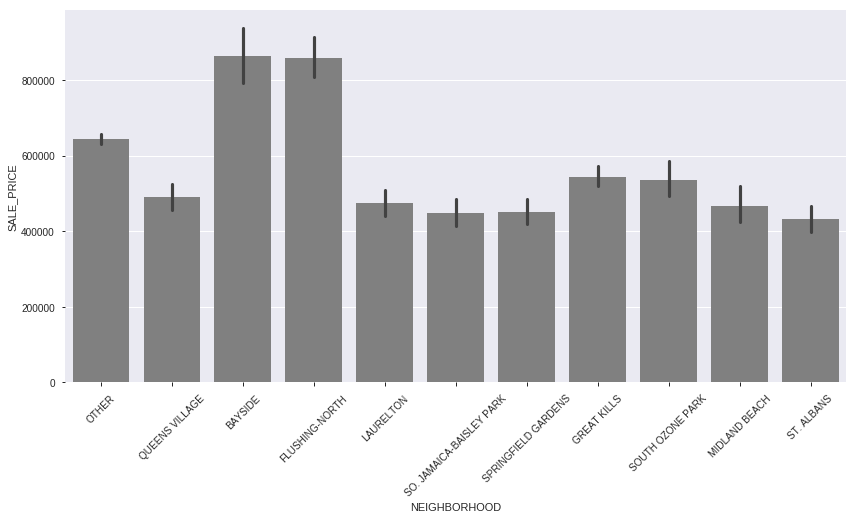

In [246]:
# let's reduce the cardinality by keeping only top 10 and rest grouped as other
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# Filter locations based on top10 neighborhoods, and not as OTHERS
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD']='OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] ='OTHER' 

sns.catplot(x='NEIGHBORHOOD', y='SALE_PRICE', data=train, color='grey',  kind='bar', height=6, aspect=2);
plt.xticks(rotation=45);

###TOTAL_UNITS, RESIDENTIAL_UNITS, COMMERCIAL_UNITS vs. SALE_PRICE

In [247]:
#First, let's verify if the RESIDENTIAL_UNITS + COMMERICAL_UNITS = TOTAL_UNITS

#if it is, we can just discard other, and keep TOTAL_UNITS
(train['RESIDENTIAL_UNITS'] + train['COMMERCIAL_UNITS']).value_counts()

1.0    2446
2.0      39
3.0       1
dtype: int64

In [248]:
train['TOTAL_UNITS'].value_counts()

1.0    2446
2.0      39
3.0       1
Name: TOTAL_UNITS, dtype: int64

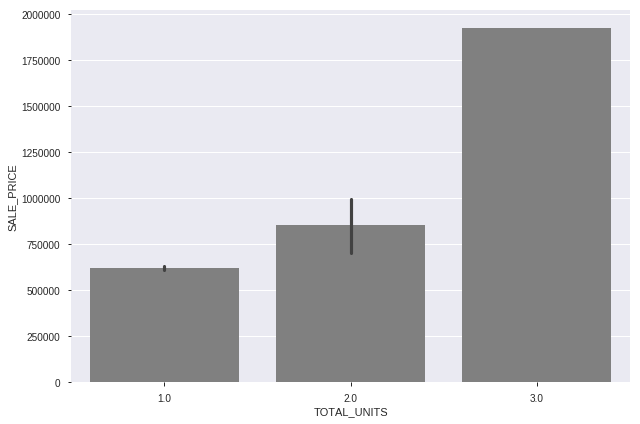

In [249]:
# it is the same, let's keep TOTAL_UNITS, and drop the others out.
train = train.drop(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS'], axis=1)
test = test.drop(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS'], axis=1)
# Total unit is the good indicator of sale price
sns.catplot(x='TOTAL_UNITS', y='SALE_PRICE', data=train, kind='bar', color='grey', height=6, aspect=1.5);

###Start simple & fast, with a subset of columns
Just numeric columns with no missing values

In [250]:
train_subset = train.select_dtypes('number').dropna(axis= 'columns')
test_subset = test.select_dtypes('number').dropna(axis='columns')

assert all(train_subset.columns == test_subset.columns)
target = 'SALE_PRICE'
features= train_subset.columns.drop(target)

X_train= train_subset[features]
y_train = train_subset[target]
X_test = test_subset[features]
y_test= test_subset[target]

X_train.shape , X_test.shape, y_train.shape


((2486, 7), (637, 7), (2486,))

In [251]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model= LinearRegression().fit(X_train , y_train)
y_pred= model.predict(X_test)

# calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE with subset of numeric column only: {mae:.0f}')

# calculation of r_squared and r_squared_adj
mse = mean_squared_error(y_test , y_pred) 
print(f'MSE with subset of numeric column only: {mse:.0f}')

# calculation of rrot mean square error
RMSE = np.sqrt(mse)
print(f'RMSE with subset of numeric column only: {RMSE:.0f}')

#Calculation of adj r_square
R_square = r2_score(y_test, y_pred)
print(f'R_square with subset of numeric column only: {R_square}')
#y_pred.mean()

MAE with subset of numeric column only: 162511
MSE with subset of numeric column only: 57468404522
RMSE with subset of numeric column only: 239726
R_square with subset of numeric column only: 0.36171069100539355


In [0]:
def lmodel(X_train, X_test, y_train, y_test):
    # Instantiate Linear Regression Mode
    model = LinearRegression().fit(X_train, y_train)

    # Store metrics   
    results = {}
    # Add model to results
    results['model'] = model
    
    # Calculate metrics on training data
    # Add R^2 
    results['train_r_squared'] = model.score(X_train, y_train)
    # Predict
    y_train_hat = model.predict(X_train)
    # MSE
    results['train_MSE'] = mean_squared_error(y_train, y_train_hat)
    # RMSE
    results['train_RMSE'] = np.sqrt(results['train_MSE'])
    # MAE
    results['train_MAE'] = mean_absolute_error(y_train, y_train_hat)

    # Calculate metrics on the test data
    # Add R^2 
    results['test_r_squared'] = model.score(X_test, y_test)
    # Predict
    y_test_hat = model.predict(X_test)
    # MSE
    results['test_MSE'] = mean_squared_error(y_test, y_test_hat)
    # RMSE
    results['test_RMSE'] = np.sqrt(results['test_MSE'])
    # MAE
    results['test_MAE'] = mean_absolute_error(y_test, y_test_hat)
    return results
def print_lm(results):
    print("""
    ----------- Linear Regression Model Results -------------
    Training Set
    R^2: {:.2f} (Explained variance score: 1 is perfect prediction)
    MSE: {:.2f}
    RMSE: {:.2f}
    MAE: ${:.2f}

    Test Set
    R^2: {:.2f} (Explained variance score: 1 is perfect prediction)
    MSE: {:.2f}
    RMSE: {:.2f}
    MAE: ${:.2f}
    """.format(results['train_r_squared'], results['train_MSE'], results['train_RMSE'], results['train_MAE'], results['test_r_squared'], results['test_MSE'], results['test_RMSE'], results['test_MAE']))

In [253]:
results= lmodel(X_train, X_test, y_train, y_test)
print_lm(results)


    ----------- Linear Regression Model Results -------------
    Training Set
    R^2: 0.39 (Explained variance score: 1 is perfect prediction)
    MSE: 52962892773.65
    RMSE: 230136.68
    MAE: $163890.18

    Test Set
    R^2: 0.36 (Explained variance score: 1 is perfect prediction)
    MSE: 57468404522.11
    RMSE: 239725.69
    MAE: $162510.94
    


In [0]:
#def linear_model(X_train, y_train, X_test, y_train, y_test):
  
  # Instantiate Linear  model
  model= LinearRegression().fit(X_train, y_train)
  
  # store the matrics
  
#return  
    

##Complex Linear Regression

####1.model with one hot encoding

###Do one-hot encoding of categorical features.

In [256]:
# look the categorical features in data
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_AT_TIME_OF_SALE,2486,10,A1,921,NaN,NaN
NEIGHBORHOOD,2486,11,OTHER,1883,NaN,NaN
SALE_DATE,2486,68,2019-01-31 00:00:00,77,2019-01-01 00:00:00,2019-03-30 00:00:00
YEAR_BUILT,2486,85,1970-01-01 00:00:00.000001920,290,1970-01-01 00:00:00.000001890,1970-01-01 00:00:00.000002018


In [257]:
import category_encoders as ce

#Subset feature and select target

cat_features = ['NEIGHBORHOOD', 'BUILDING_CLASS_AT_TIME_OF_SALE']
numeric_features= train.select_dtypes('number').columns.tolist()
combined_features = cat_features + numeric_features
traget = 'SALE_PRICE'

# split feature  and traget to X, y train and test split
X_train = train[combined_features]
X_test = test[combined_features]
y_train = train[target]
y_test = test[target]

assert all (X_train.columns == X_test.columns)

# do one hot encoding
encoder = ce.OneHotEncoder(use_cat_names= True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# assert columns are same
assert X_train_encoded.shape[1] == X_test_encoded.shape[1]

results = lmodel(X_train_encoded, X_test_encoded, y_train, y_test)
print_lm(results)
X_train_encoded.shape


    ----------- Linear Regression Model Results -------------
    Training Set
    R^2: 1.00 (Explained variance score: 1 is perfect prediction)
    MSE: 0.00
    RMSE: 0.00
    MAE: $0.00

    Test Set
    R^2: 1.00 (Explained variance score: 1 is perfect prediction)
    MSE: 0.00
    RMSE: 0.00
    MAE: $0.00
    


(2486, 29)

In [258]:
print('Intercept: ', results['model'].intercept_)
print(pd.Series(results['model'].coef_, X_train_encoded.columns.tolist()).to_string())

Intercept:  2.3283064365386963e-10
NEIGHBORHOOD_OTHER                       9.871346e-11
NEIGHBORHOOD_QUEENS VILLAGE             -1.656071e-10
NEIGHBORHOOD_BAYSIDE                    -5.910717e-11
NEIGHBORHOOD_FLUSHING-NORTH             -6.575249e-11
NEIGHBORHOOD_LAURELTON                   4.113687e-11
NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK    2.963295e-11
NEIGHBORHOOD_SPRINGFIELD GARDENS         4.607041e-11
NEIGHBORHOOD_GREAT KILLS                -1.262356e-11
NEIGHBORHOOD_SOUTH OZONE PARK            4.387424e-11
NEIGHBORHOOD_MIDLAND BEACH               6.193473e-12
NEIGHBORHOOD_ST. ALBANS                  3.746838e-11
BUILDING_CLASS_AT_TIME_OF_SALE_A9        1.422368e-11
BUILDING_CLASS_AT_TIME_OF_SALE_A1       -5.561948e-12
BUILDING_CLASS_AT_TIME_OF_SALE_A5        2.431257e-11
BUILDING_CLASS_AT_TIME_OF_SALE_A0       -4.826825e-11
BUILDING_CLASS_AT_TIME_OF_SALE_A2        3.351113e-12
BUILDING_CLASS_AT_TIME_OF_SALE_A3        3.386308e-10
BUILDING_CLASS_AT_TIME_OF_SALE_S1       -3.4375

##Model with SelectKBest.

In [259]:
# Select 10 feature
selector = SelectKBest(score_func=f_regression, k = 10)
X_train_selected = selector.fit_transform(X_train_encoded, y_train)
X_test_selected = selector.transform(X_test_encoded)

assert X_train_selected.shape[1] == X_test_selected.shape[1]

X_train_selected.shape, X_test_selected.shape


((2486, 10), (637, 10))

In [260]:
results= lmodel(X_train_selected, X_test_selected, y_train, y_test)
print_lm(results)


    ----------- Linear Regression Model Results -------------
    Training Set
    R^2: 0.40 (Explained variance score: 1 is perfect prediction)
    MSE: 51977439671.75
    RMSE: 227985.61
    MAE: $161728.47

    Test Set
    R^2: 0.37 (Explained variance score: 1 is perfect prediction)
    MSE: 57076039618.83
    RMSE: 238905.92
    MAE: $160011.05
    


In [262]:
def find_k_best_features(X_train, X_test, y_train, y_test):
    for k in range(1, len(X_train.columns)+1):
        print(f'{k} features')
        selector = SelectKBest(score_func=f_regression, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)    
        model = LinearRegression()
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r_square = model.score(X_test_selected, y_test)
        print('''
        R^2: {:.2f}
        MSE: {:.2f}
        RMSE: {:.2f}
        MAE: ${:.2f}
        '''.format(r_square, mse, rmse, mae))


find_k_best_features(X_train_encoded, X_test_encoded, y_train, y_test)

1 features

        R^2: 0.19
        MSE: 72763551515.88
        RMSE: 269747.20
        MAE: $186993.23
        
2 features

        R^2: 0.21
        MSE: 70880185392.21
        RMSE: 266233.33
        MAE: $182972.67
        
3 features

        R^2: 0.22
        MSE: 70608455290.47
        RMSE: 265722.52
        MAE: $182614.34
        
4 features

        R^2: 0.24
        MSE: 68209021465.92
        RMSE: 261168.57
        MAE: $182390.62
        
5 features

        R^2: 0.25
        MSE: 67844408161.96
        RMSE: 260469.59
        MAE: $178136.02
        
6 features

        R^2: 0.36
        MSE: 57585338867.22
        RMSE: 239969.45
        MAE: $161515.86
        
7 features

        R^2: 0.36
        MSE: 57291096921.77
        RMSE: 239355.59
        MAE: $161669.15
        
8 features

        R^2: 0.36
        MSE: 57334389129.25
        RMSE: 239446.00
        MAE: $161835.53
        
9 features

        R^2: 0.36
        MSE: 57554193653.93
        RMSE: 239904.5

In [261]:
# calculate R and adj Rsquare
import statsmodels.api as sm
X1 = sm.add_constant(X_train_selected)
result = sm.OLS(y_train, X1).fit()
print(result.rsquared, result.rsquared_adj)


0.40341079189971174 0.4010003304528419


###ZIP_CODE vs. SALE_PRICE


In [0]:
train['ZIP_CODE'].describe()

In [0]:
train['ZIP_CODE'].value_counts()

In [0]:
sns.lmplot(x='ZIP_CODE', y= 'SALE_PRICE', data= train, scatter_kws= dict(alpha=0.05));

###YEAR_BUILT vs. SALE_PRICE


In [0]:

train['YEAR_BUILT'].describe()
train['YEAR_BUILT'].value_counts()

In [0]:
train['SALE_DATE'].value_counts()